<a href="https://colab.research.google.com/github/sju0924/sju0924/blob/master/%EC%A7%80%EC%96%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
\
# Accessing My Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [4]:
!unzip '/content/drive/MyDrive/Colab Notebooks/data/comp/deeplearning2021competition.zip' -d .

Archive:  /content/drive/MyDrive/Colab Notebooks/data/comp/deeplearning2021competition.zip
replace ./food_data/meta/meta/classes.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./food_data/meta/meta/labels.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Define Model

In [11]:
import torch
import torch.nn as nn
import time

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import matplotlib.pyplot as plt



In [7]:
# 데이터 전처리
trans = transforms.Compose([transforms.Resize((224,224)),
                            transforms.ToTensor(),
                           transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])

In [42]:
data_root = '/content/food_data/processed_images'
dataset = ImageFolder(root = data_root,transform = trans)

In [30]:
meta_classes = open("/content/food_data/meta/meta/classes.txt", "r").read().split()
meta_labels = open("/content/food_data/meta/meta/labels.txt", "r").read().split()
meta_test = open("/content/food_data/meta/meta/test.txt", "r").read().split()
meta_train = open("/content/food_data/meta/meta/train.txt", "r").read().split()

def dict_map(classes):
  res = {}
  for i, item in enumerate(classes):
    res[item] = i
  return res

print(dict_map(meta_classes))

{'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheesecake': 16, 'cheese_plate': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34, 'escargots': 35, 'falafel': 36, 'filet_mignon': 37, 'fish_and_chips': 38, 'foie_gras': 39, 'french_fries': 40, 'french_onion_soup': 41, 'french_toast': 42, 'fried_calamari': 43, 'fried_rice': 44, 'frozen_yogurt': 45, 'garlic_bread': 46, 'gnocchi': 47, 'greek_salad': 48, 'grilled_cheese_sandwich': 49, 'grilled_salmon': 50, 'guacamole': 5

In [43]:
BATCHSIZE = 30

train_dataset = FoodImageFolder(
        '/content/food_data/processed_images/', transform=trans, txt_file='/content/food_data/meta/meta/train.txt')
train_loader = DataLoader(test_dataset, batch_size=BATCHSIZE, num_workers=2, shuffle=False)

38782


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


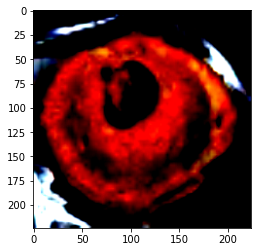

In [46]:
plt.imshow(train_dataset[3][0].permute(1,2,0))

In [ ]:
mymodel = models.regnet_y_400mf()
mymodel.fc = nn.Sequential(
            nn.Linear(440,90)
)
mymodel

## utils

In [ ]:
class AverageMeter(object):
    r"""Computes and stores the average and current value
    """
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, *meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def print(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def accuracy(output, target, topk=(1,)):
    r"""Computes the accuracy over the $k$ top predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # _, pred = output.topk(maxk, 1, True, True)
        # pred = pred.t()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))

        # faster topk (ref: https://github.com/pytorch/pytorch/issues/22812)
        _, idx = output.sort(descending=True)
        pred = idx[:,:maxk]
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [ ]:
from typing import Any, Callable, cast, Dict, List, Optional, Tuple
from PIL import Image

IMG_EXTENSIONS = (".jpg", ".jpeg", ".png", ".ppm", ".bmp", ".pgm", ".tif", ".tiff", ".webp")

from PIL import Image
def pil_loader(path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")

def default_loader(path: str) -> Any:
    from torchvision import get_image_backend

    if get_image_backend() == "accimage":
        return accimage_loader(path)
    else:
        return pil_loader(path)

class FoodImageFolder(torchvision.datasets.DatasetFolder):
    """A generic data loader where the images are arranged in this way by default: ::
        root/dog/xxx.png
        root/dog/xxy.png
        root/dog/[...]/xxz.png
        root/cat/123.png
        root/cat/nsdf3.png
        root/cat/[...]/asd932_.png
    This class inherits from :class:`~torchvision.datasets.DatasetFolder` so
    the same methods can be overridden to customize the dataset.
    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
        is_valid_file (callable, optional): A function that takes path of an Image file
            and check if the file is a valid file (used to check of corrupt files)
     Attributes:
        classes (list): List of the class names sorted alphabetically.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples
    """

    def __init__(
        self,
        root: str,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        loader: Callable[[str], Any] = default_loader,
        is_valid_file: Optional[Callable[[str], bool]] = None,
        txt_file=None
    ):
        super().__init__(
            root,
            loader,
            IMG_EXTENSIONS if is_valid_file is None else None,
            transform=transform,
            target_transform=target_transform,
            is_valid_file=is_valid_file,
        )

        if txt_file is not None:
            f = open(txt_file, 'r')
            id = 0

            path_list = []
            while True:
                line = f.readline()[:-1]
                if not line: break
                path = root+line+".jpg"
                path_list.append(path)

            f.close()

            self.imgs = []
            for sample in self.samples:
                if sample[0] in path_list:
                    self.imgs.append(sample)
            
            self.samples = self.imgs
        else:
            self.imgs = self.samples

        print(len(self.imgs))

## Hyperparameters

In [52]:
SAVEPATH = '/content/drive/My Drive/Colab Notebooks/deeplearning/'
WEIGHTDECAY = 1e-4
MOMENTUM = 0.9
BATCHSIZE = 256
LR = 0.1
EPOCHS = 25
PRINTFREQ = 20

## Train Model

In [ ]:
def main():
    model = mymodel

    ##### optimizer / learning rate scheduler / criterion #####
    optimizer = torch.optim.SGD(model.parameters(), lr=LR,
                                momentum=MOMENTUM, weight_decay=WEIGHTDECAY,
                                nesterov=True)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [20],
                                                     gamma=0.1)
    criterion = torch.nn.CrossEntropyLoss()
    ###########################################################

    model = model.cuda()
    criterion = criterion.cuda()

    # Check number of parameters your model
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {pytorch_total_params}")

    #model.load_state_dict(torch.load(SAVEPATH+'model_weight.pth'))


    last_top1_acc = 0
    for epoch in range(EPOCHS):
        print("\n----- epoch: {}, lr: {} -----".format(
            epoch, optimizer.param_groups[0]["lr"]))

        # train for one epoch
        start_time = time.time()
        last_top1_acc = train(train_loader, epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to train this epoch\n'.format(
            elapsed_time))

        # learning rate scheduling
        scheduler.step()

        # Save model each epoch
        torch.save(model.state_dict(), SAVEPATH+'model_weight.pth')

    print(f"Last Top-1 Accuracy: {last_top1_acc}")
    print(f"Number of parameters: {pytorch_total_params}")



def train(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        input = input.cuda()
        target = target.cuda()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINTFREQ == 0:
            progress.print(i)

    print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))
    return top1.avg


if __name__ == "__main__":
    main()

Number of parameters: 3942834

----- epoch: 0, lr: 0.1 -----
Epoch: [0][  0/689]	Time  0.569 ( 0.569)	Data  0.204 ( 0.204)	Loss 4.9198e+00 (4.9198e+00)	Acc@1   0.00 (  0.00)	Acc@5   0.00 (  0.00)
Epoch: [0][ 20/689]	Time  0.367 ( 0.384)	Data  0.008 ( 0.016)	Loss 5.7659e+00 (2.7206e+01)	Acc@1  86.67 ( 67.46)	Acc@5 100.00 ( 92.06)
Epoch: [0][ 40/689]	Time  0.369 ( 0.375)	Data  0.009 ( 0.011)	Loss 5.3781e+00 (1.6180e+01)	Acc@1   0.00 ( 46.50)	Acc@5 100.00 ( 92.52)
Epoch: [0][ 60/689]	Time  0.368 ( 0.373)	Data  0.004 ( 0.010)	Loss 3.3548e+00 (1.2384e+01)	Acc@1   0.00 ( 31.26)	Acc@5 100.00 ( 76.28)
Epoch: [0][ 80/689]	Time  0.367 ( 0.372)	Data  0.006 ( 0.009)	Loss 5.8358e+00 (1.0485e+01)	Acc@1   0.00 ( 23.54)	Acc@5   0.00 ( 65.72)
Epoch: [0][100/689]	Time  0.370 ( 0.371)	Data  0.007 ( 0.008)	Loss 4.7976e+00 (9.3853e+00)	Acc@1   0.00 ( 18.88)	Acc@5   0.00 ( 55.48)
Epoch: [0][120/689]	Time  0.371 ( 0.371)	Data  0.010 ( 0.008)	Loss 4.4259e+00 (8.6334e+00)	Acc@1   0.00 ( 15.76)	Acc@5  56.67 ( 5

## Make an evalutation csv file

This code makes an evaluation csv file for kaggle submission.

**Never change below code!!!** (except test_loader setting)

In [ ]:
import torch
import pandas as pd
import argparse
import time
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader


def eval():
    test_transform = transforms.Compose([
        transforms.ToTensor()
    ])

    test_dataset = FoodImageFolder(
        './food_data/processed_images/', transform=test_transform, txt_file='./food_data/meta/meta/test.txt')
    test_loader = DataLoader(test_dataset, batch_size=BATCHSIZE, num_workers=2, shuffle=False)

    model = resnet34()
    model = model.cuda()
    model.load_state_dict(torch.load(SAVEPATH+'model_weight.pth'))

    model.eval()
    print('Make an evaluation csv file for kaggle submission...')
    Category = []
    i = 0
    for input, _ in test_loader:
        i+=1
        input = input.cuda()
        output = model(input)
        output = torch.argmax(output, dim=1)
        Category = Category + output.tolist()

    Id = list(range(0, 20665))
    samples = {
       'Id': Id,
       'Category': Category 
    }
    df = pd.DataFrame(samples, columns=['Id', 'Category'])

    df.to_csv(SAVEPATH+'submission.csv', index=False)
    print('Done!!')


if __name__ == "__main__":
    eval()

20665
Make an evaluation csv file for kaggle submission...
Done!!


## Upload your submission on kaggle

1. Download the submission csv file  
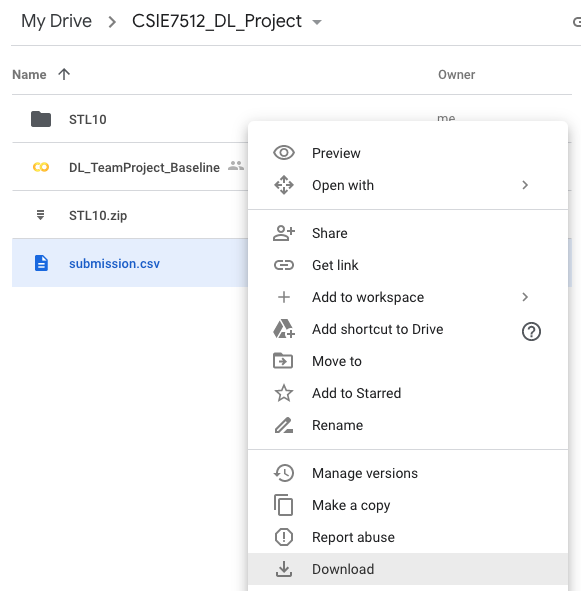

2. Go to our kaggle submission link and click `Submit Predicitions` button  
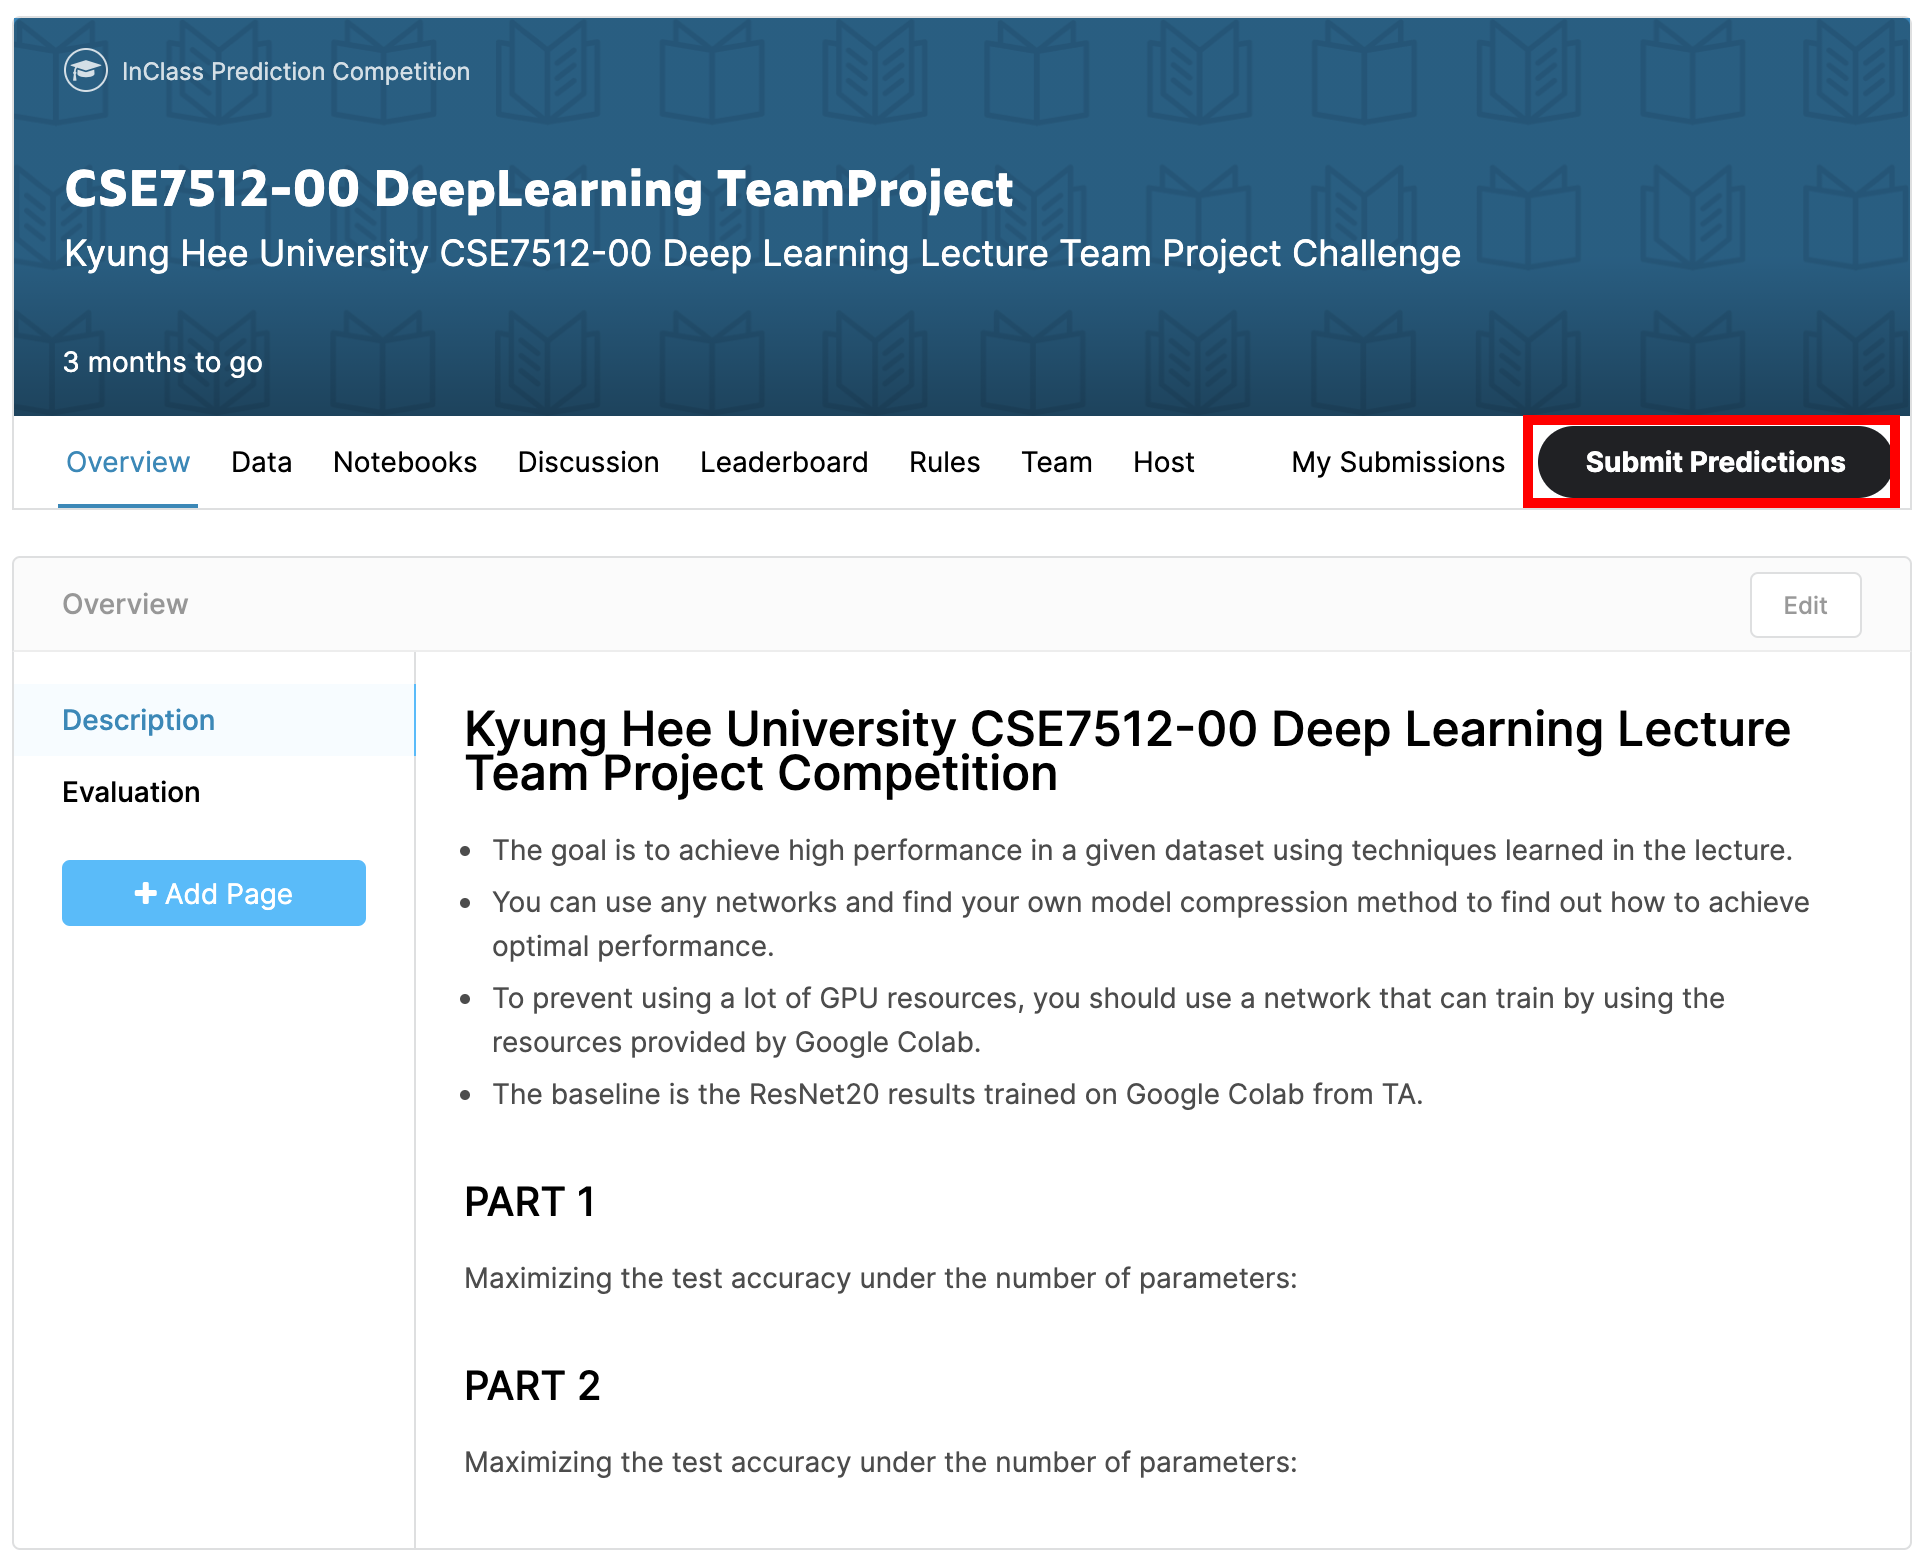

3. Upload Submission `csv` file and click `make submission` button  
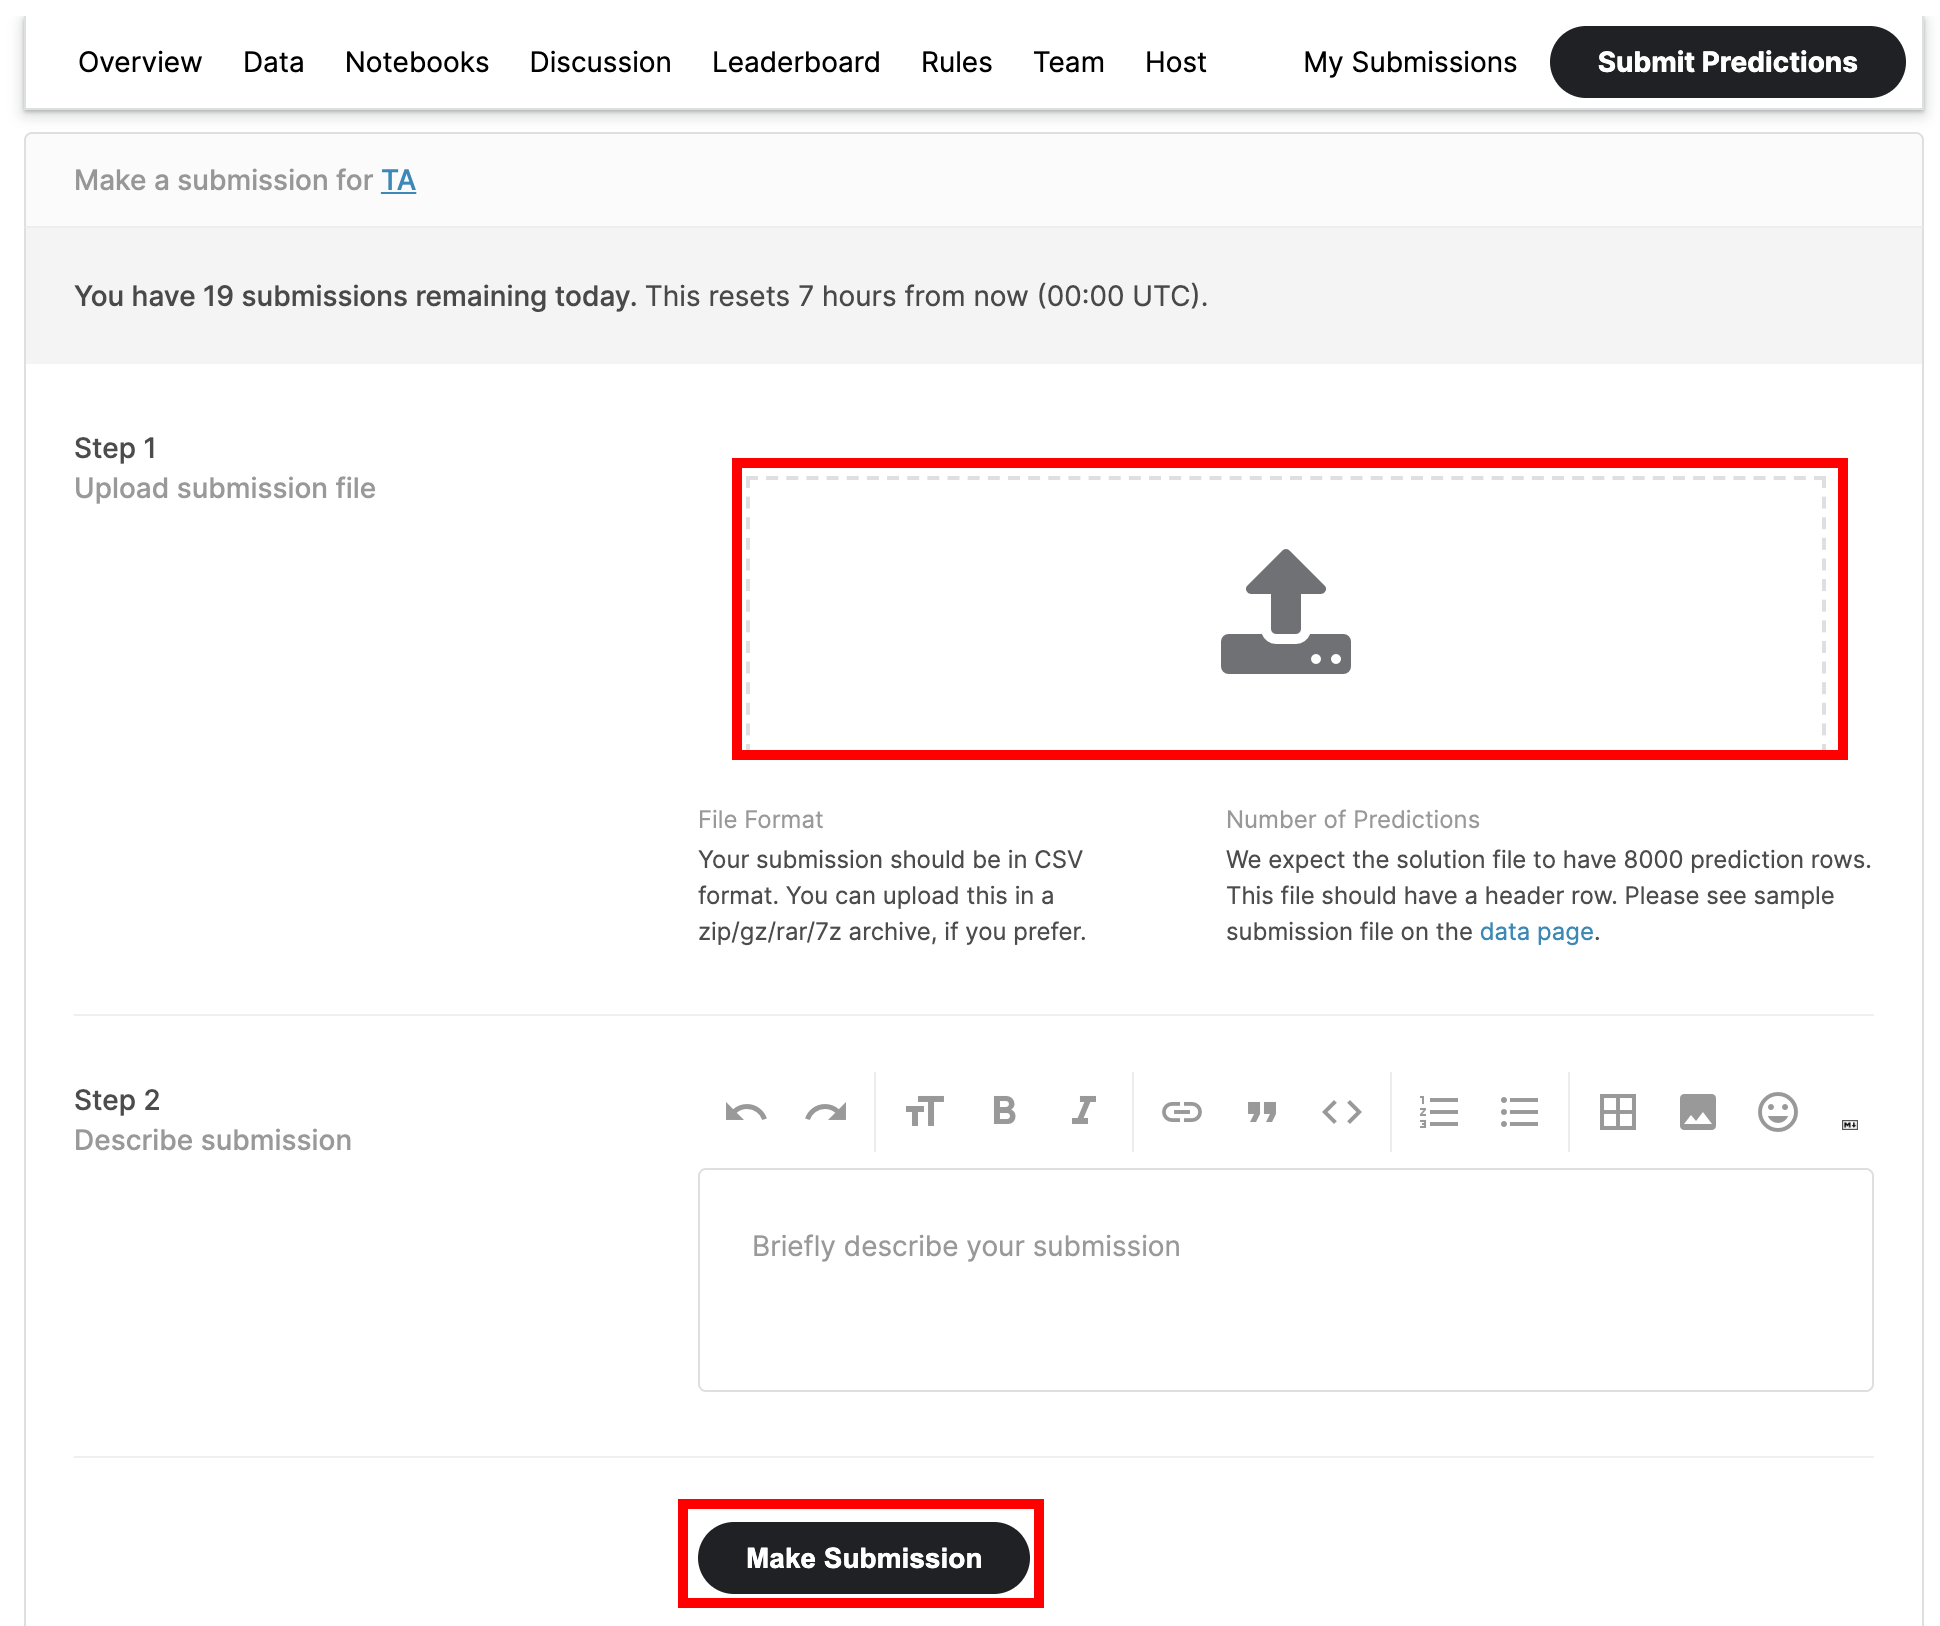

